# Benchmarking Matrix generation script

Important remarks :

- Approximation results as the load of the active ui animation is hard to simulate aside the matrix calculation. Currently a large animation with 0.5 boat is run beside this script

- Number of time deltas per combination is chosen arbitrarily, 10 in this case, for the sake of simplicity, it is totally possible for a data to be more heavy on a specific time range that may not be covered in the selected deltas

In [5]:
import numpy as np
from shapely.geometry import Point
from pymeos.db.psycopg import MobilityDB

from pymeos import *
import os
import sys
from datetime import timedelta, datetime
from pymeos import *
import time
from tqdm import tqdm
import itertools
import shutil
import math
import subprocess
from collections import deque


MATRIX_DIRECTORY_PATH ="/home/ali/matrices/" 
if os.path.exists(MATRIX_DIRECTORY_PATH):
    shutil.rmtree(MATRIX_DIRECTORY_PATH)
    os.makedirs(MATRIX_DIRECTORY_PATH)
else:
    os.makedirs(MATRIX_DIRECTORY_PATH)
pymeos_initialize()


In [6]:

def get_folder_size_mb(dir_name):
    total_size = 0
    sizes = deque(maxlen=3)
    for dirpath, dirnames, filenames in os.walk(dir_name):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            # Skip if it is symbolic link
            if not os.path.islink(file_path):
                sizes.append(os.path.getsize(file_path))
    # Convert size to MB
    total_size_mb = sum(sizes) / (1024 * 1024)
    return total_size_mb


In [7]:


"""
Iterate over all the possible combinations of frames and percentages

for each combination :
    
    Create 3 time deltas
    store : time for each time delta
    store : maximum time for each time delta
    store : average time for each time delta
    
    Calculate FPS using : Frames / maximum time for each time delta

    Store the FPS for each combination

    store the memory used by all 3 time delta in local disk


"""

SRID = 4326
DATABASE_NAME = "mobilitydb"
TPOINT_TABLE_NAME = "PyMEOS_demo"
TPOINT_ID_COLUMN_NAME = "MMSI"
TPOINT_COLUMN_NAME = "trajectory"
x_min = -180
y_min = -90
x_max = 180
y_max = 90
extent_list = [x_min, y_min, x_max, y_max]
Time_granularities = {
                    # "MILLISECOND" : timedelta(milliseconds=1),
                      "SECOND" : timedelta(seconds=1),
                      "MINUTE" : timedelta(minutes=1),
                    #   "HOUR" : timedelta(hours=1),
                    }
GRANULARITY = Time_granularities["SECOND"]

connection_params = {
        "host": "localhost",
        "port": 5432,
        "dbname": DATABASE_NAME,
        "user": "postgres",
        "password": "postgres"
        }
                
connection = MobilityDB.connect(**connection_params)
cursor = connection.cursor()

cursor.execute(f"SELECT {TPOINT_ID_COLUMN_NAME} FROM public.{TPOINT_TABLE_NAME};")
Total_ids = cursor.fetchall()

cursor.execute(f"SELECT MIN(startTimestamp({TPOINT_COLUMN_NAME})) AS earliest_timestamp FROM public.{TPOINT_TABLE_NAME};")
start_date = cursor.fetchone()[0]
cursor.execute(f"SELECT MAX(endTimestamp({TPOINT_COLUMN_NAME})) AS latest_timestamp FROM public.{TPOINT_TABLE_NAME};")
end_date = cursor.fetchone()[0]

total_frames = math.ceil( (end_date - start_date) // GRANULARITY ) + 1

timestamps = [start_date + i * GRANULARITY for i in range(total_frames)]
timestamps = [dt.replace(tzinfo=None) for dt in timestamps]
timestamps_strings = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in timestamps]


TIME_DELTA_COUNT = 10


Frames = [10, 60, 120, 240, 480, 960]
Percentages = [0.1, 0.5,  1]

number_of_objects={} # Store the number of objects for each percentage
times = {} # Store the time for each time delta
memory_used = {} # Store the memory used for each combination

combinations = tqdm(list(itertools.product(Frames, Percentages)))

for combination in combinations:
    combinations.set_description(f"Combination {combination}")
    frame, percentage = combination

    
    ids_list = Total_ids[:int(len(Total_ids)*percentage)]
    number_of_objects[percentage] = len(ids_list)


    # print(combination)
    dir_name = f"/home/ali/matrices/{frame}_{percentage}"
    # print(dir_name)
    os.mkdir(dir_name)
   
    t_deltas = tqdm([(i, (i+frame)-1) for i in range(0, 10*frame, frame)]) 
    # print(t_deltas)
    times[combination] = []
    for delta in t_deltas:
        t_deltas.set_description(f"Time delta {delta}")
        now = time.time()
        x_min,y_min, x_max, y_max = extent_list
        begin_frame, end_frame = delta
        arguments = [begin_frame, end_frame, percentage, x_min, y_min, x_max, y_max]
        arguments = [str(arg) for arg in arguments]
        arguments += [timestamps_strings[begin_frame],  str(len(timestamps)),
                'SECOND',
                dir_name,
                'mobilitydb',
                'pymeos_demo',
                'MMSI',
                'trajectory']
     

        python_path = sys.executable
        process_B_path = f"/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py"
        
        command = [python_path, process_B_path, *arguments]
        result = subprocess.run(command, capture_output=True, text=True)
        print(result)
        
        loaded_matrix = np.load(f"{dir_name}/matrix_{begin_frame}.npy", allow_pickle=True)

        TIME_total = time.time() - now
        times[combination].append(TIME_total)
    size = get_folder_size_mb(dir_name) 
    memory_used[combination] = size
    shutil.rmtree(dir_name)
        
    
    



Combination (10, 0.1):   0%|          | 0/18 [00:00<?, ?it/s]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '9', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.037729740142822266 seconds, 1.131892204284668 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '10', '19', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:10', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 10 created in 0.10251832008361816 seconds, 3.075549602508545 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '20', '29', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:20', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 20 created in 0.09531092643737793 seconds, 2.859327793121338 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '30', '39', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:30', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 30 created in 0.08017206192016602 seconds, 2.4051618576049805 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '40', '49', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:40', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 40 created in 0.08383941650390625 seconds, 2.5151824951171875 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '50', '59', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:50', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 50 created in 0.1200873851776123 seconds, 3.602621555328369 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '60', '69', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 0.08543634414672852 seconds, 2.5630903244018555 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '70', '79', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:10', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 70 created in 0.10093402862548828 seconds, 3.0280208587646484 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '80', '89', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:20', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 80 created in 0.0868673324584961 seconds, 2.606019973754883 frames for 30 fps animation.\n', stderr='')


Combination (10, 0.5):   6%|▌         | 1/18 [00:08<02:27,  8.69s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '90', '99', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:30', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 90 created in 0.0922093391418457 seconds, 2.766280174255371 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '9', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.1589052677154541 seconds, 4.767158031463623 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '10', '19', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:10', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 10 created in 0.34005284309387207 seconds, 10.201585292816162 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '20', '29', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:20', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 20 created in 0.47577857971191406 seconds, 14.273357391357422 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '30', '39', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:30', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 30 created in 0.4355607032775879 seconds, 13.066821098327637 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '40', '49', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:40', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 40 created in 0.5415399074554443 seconds, 16.24619722366333 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '50', '59', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:50', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 50 created in 0.5558788776397705 seconds, 16.676366329193115 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '60', '69', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 0.5655794143676758 seconds, 16.967382431030273 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '70', '79', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:10', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 70 created in 0.839698314666748 seconds, 25.19094944000244 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '80', '89', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:20', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 80 created in 0.6725597381591797 seconds, 20.17679214477539 frames for 30 fps animation.\n', stderr='')


Combination (10, 1):  11%|█         | 2/18 [00:27<03:58, 14.89s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '90', '99', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:30', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 90 created in 0.7151761054992676 seconds, 21.455283164978027 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '9', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.4525339603424072 seconds, 13.576018810272217 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '10', '19', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:10', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 10 created in 0.7941718101501465 seconds, 23.825154304504395 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '20', '29', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:20', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 20 created in 0.9383726119995117 seconds, 28.15117835998535 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '30', '39', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:30', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 30 created in 1.0404789447784424 seconds, 31.21436834335327 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '40', '49', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:40', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 40 created in 1.0706486701965332 seconds, 32.119460105895996 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '50', '59', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:50', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 50 created in 1.2157328128814697 seconds, 36.47198438644409 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '60', '69', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 1.2648646831512451 seconds, 37.94594049453735 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '70', '79', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:10', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 70 created in 1.2879469394683838 seconds, 38.638408184051514 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '80', '89', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:20', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 80 created in 1.4106154441833496 seconds, 42.31846332550049 frames for 30 fps animation.\n', stderr='')


Combination (60, 0.1):  17%|█▋        | 3/18 [01:05<06:19, 25.28s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '90', '99', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:30', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 90 created in 1.4702024459838867 seconds, 44.1060733795166 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '59', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.17780661582946777 seconds, 5.334198474884033 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '60', '119', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 0.3409912586212158 seconds, 10.229737758636475 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '120', '179', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 0.40285372734069824 seconds, 12.085611820220947 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '180', '239', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:03:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 180 created in 0.4244413375854492 seconds, 12.733240127563477 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '299', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 0.4438042640686035 seconds, 13.314127922058105 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '300', '359', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:05:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 300 created in 0.44284582138061523 seconds, 13.285374641418457 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '360', '419', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 0.4956679344177246 seconds, 14.870038032531738 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '420', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:07:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 420 created in 0.4837222099304199 seconds, 14.511666297912598 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '539', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 0.4735105037689209 seconds, 14.205315113067627 frames for 30 fps animation.\n', stderr='')


Combination (60, 0.5):  22%|██▏       | 4/18 [01:17<04:37, 19.86s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '540', '599', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:09:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 540 created in 0.5076019763946533 seconds, 15.2280592918396 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '59', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 1.2126615047454834 seconds, 36.3798451423645 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '60', '119', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 2.307894229888916 seconds, 69.23682689666748 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '120', '179', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 2.8552043437957764 seconds, 85.65613031387329 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '180', '239', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:03:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 180 created in 2.946345567703247 seconds, 88.39036703109741 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '299', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 3.0553030967712402 seconds, 91.6590929031372 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '300', '359', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:05:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 300 created in 3.1300973892211914 seconds, 93.90292167663574 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '360', '419', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 3.1730353832244873 seconds, 95.19106149673462 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '420', '479', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:07:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 420 created in 3.282896041870117 seconds, 98.48688125610352 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '539', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 3.1825854778289795 seconds, 95.47756433486938 frames for 30 fps animation.\n', stderr='')


Combination (60, 1):  28%|██▊       | 5/18 [01:59<06:05, 28.08s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '540', '599', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:09:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 540 created in 3.3210787773132324 seconds, 99.63236331939697 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '59', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 2.8890576362609863 seconds, 86.67172908782959 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '60', '119', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 4.984721899032593 seconds, 149.54165697097778 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '120', '179', '1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 5.704839468002319 seconds, 171.14518404006958 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '180', '239', '1', '-180', '-90', '180', '90', '2023-06-01 00:03:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 180 created in 6.020256757736206 seconds, 180.60770273208618 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '299', '1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 6.182138204574585 seconds, 185.46414613723755 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '300', '359', '1', '-180', '-90', '180', '90', '2023-06-01 00:05:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 300 created in 6.171616315841675 seconds, 185.14848947525024 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '360', '419', '1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 6.489666223526001 seconds, 194.68998670578003 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '420', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:07:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 420 created in 6.4932897090911865 seconds, 194.7986912727356 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '539', '1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 6.395222187042236 seconds, 191.8566656112671 frames for 30 fps animation.\n', stderr='')


Combination (120, 0.1):  33%|███▎      | 6/18 [03:24<09:29, 47.48s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '540', '599', '1', '-180', '-90', '180', '90', '2023-06-01 00:09:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 540 created in 6.451624870300293 seconds, 193.5487461090088 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '119', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.4230837821960449 seconds, 12.692513465881348 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '120', '239', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 0.7639617919921875 seconds, 22.918853759765625 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '359', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 0.8238222599029541 seconds, 24.714667797088623 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '360', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 0.9261898994445801 seconds, 27.785696983337402 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '599', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 0.9311680793762207 seconds, 27.93504238128662 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '600', '719', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:10:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 600 created in 0.9449903964996338 seconds, 28.349711894989014 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '720', '839', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 1.0251226425170898 seconds, 30.753679275512695 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '840', '959', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:14:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 840 created in 0.9414863586425781 seconds, 28.244590759277344 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1079', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 1.0126636028289795 seconds, 30.379908084869385 frames for 30 fps animation.\n', stderr='')


Combination (120, 0.5):  39%|███▉      | 7/18 [03:41<06:50, 37.28s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1080', '1199', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:18:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1080 created in 1.078014850616455 seconds, 32.34044551849365 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '119', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 2.855518102645874 seconds, 85.66554307937622 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '120', '239', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 5.182887315750122 seconds, 155.48661947250366 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '359', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 5.521169900894165 seconds, 165.63509702682495 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '360', '479', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 5.825526475906372 seconds, 174.76579427719116 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '599', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 5.903977394104004 seconds, 177.11932182312012 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '600', '719', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:10:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 600 created in 6.155156373977661 seconds, 184.65469121932983 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '720', '839', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 6.151973009109497 seconds, 184.5591902732849 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '840', '959', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:14:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 840 created in 6.232322692871094 seconds, 186.9696807861328 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1079', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 6.28871750831604 seconds, 188.6615252494812 frames for 30 fps animation.\n', stderr='')


Combination (120, 1):  44%|████▍     | 8/18 [04:52<08:01, 48.11s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1080', '1199', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:18:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1080 created in 6.32654881477356 seconds, 189.7964644432068 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '119', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 6.47167444229126 seconds, 194.1502332687378 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '120', '239', '1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 10.763026714324951 seconds, 322.89080142974854 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '359', '1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 11.421600103378296 seconds, 342.6480031013489 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '360', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 11.884657382965088 seconds, 356.53972148895264 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '599', '1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 12.018742799758911 seconds, 360.56228399276733 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '600', '719', '1', '-180', '-90', '180', '90', '2023-06-01 00:10:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 600 created in 12.270251989364624 seconds, 368.1075596809387 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '720', '839', '1', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 12.495432376861572 seconds, 374.86297130584717 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '840', '959', '1', '-180', '-90', '180', '90', '2023-06-01 00:14:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 840 created in 12.517542839050293 seconds, 375.5262851715088 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1079', '1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 12.722190856933594 seconds, 381.6657257080078 frames for 30 fps animation.\n', stderr='')


Combination (240, 0.1):  50%|█████     | 9/18 [07:17<11:44, 78.30s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1080', '1199', '1', '-180', '-90', '180', '90', '2023-06-01 00:18:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1080 created in 13.462238550186157 seconds, 403.8671565055847 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '239', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 1.0493669509887695 seconds, 31.481008529663086 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 1.6107945442199707 seconds, 48.32383632659912 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '719', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 1.8125178813934326 seconds, 54.37553644180298 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '720', '959', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 1.798447847366333 seconds, 53.95343542098999 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1199', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 1.9827666282653809 seconds, 59.482998847961426 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1200', '1439', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:20:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1200 created in 2.0686583518981934 seconds, 62.0597505569458 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1440', '1679', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 2.0545854568481445 seconds, 61.637563705444336 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1680', '1919', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:28:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1680 created in 2.065441608428955 seconds, 61.96324825286865 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2159', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 2.1985654830932617 seconds, 65.95696449279785 frames for 30 fps animation.\n', stderr='')


Combination (240, 0.5):  56%|█████▌    | 10/18 [07:43<08:18, 62.27s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2160', '2399', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:36:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2160 created in 2.134899854660034 seconds, 64.04699563980103 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '239', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 7.1682820320129395 seconds, 215.04846096038818 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '479', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 11.013370752334595 seconds, 330.40112257003784 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '719', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 11.40755844116211 seconds, 342.2267532348633 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '720', '959', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 11.958851099014282 seconds, 358.76553297042847 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1199', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 12.1046724319458 seconds, 363.140172958374 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1200', '1439', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:20:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1200 created in 12.351608514785767 seconds, 370.548255443573 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1440', '1679', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 12.386426448822021 seconds, 371.59279346466064 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1680', '1919', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:28:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1680 created in 12.535314798355103 seconds, 376.0594439506531 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2159', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 12.578179121017456 seconds, 377.3453736305237 frames for 30 fps animation.\n', stderr='')


Combination (240, 1):  61%|██████    | 11/18 [09:55<09:45, 83.63s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2160', '2399', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:36:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2160 created in 12.59380316734314 seconds, 377.8140950202942 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '239', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 15.81301999092102 seconds, 474.3905997276306 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 22.269938230514526 seconds, 668.0981469154358 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '719', '1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 23.40853762626648 seconds, 702.2561287879944 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '720', '959', '1', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 23.836017370224 seconds, 715.08052110672 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1199', '1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 24.260345935821533 seconds, 727.810378074646 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1200', '1439', '1', '-180', '-90', '180', '90', '2023-06-01 00:20:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1200 created in 24.758753299713135 seconds, 742.762598991394 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1440', '1679', '1', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 25.03709101676941 seconds, 751.1127305030823 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1680', '1919', '1', '-180', '-90', '180', '90', '2023-06-01 00:28:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1680 created in 26.16586995124817 seconds, 784.9760985374451 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2159', '1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 26.59671902656555 seconds, 797.9015707969666 frames for 30 fps animation.\n', stderr='')


Time delta (2160, 2399): 100%|██████████| 10/10 [04:29<00:00, 26.96s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2160', '2399', '1', '-180', '-90', '180', '90', '2023-06-01 00:36:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2160 created in 26.131035566329956 seconds, 783.9310669898987 frames for 30 fps animation.\n', stderr='')



Combination (480, 0.1):  67%|██████▋   | 12/18 [14:25<14:01, 140.22s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 2.5233616828918457 seconds, 75.70085048675537 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '959', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 3.546204090118408 seconds, 106.38612270355225 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1439', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 3.888148307800293 seconds, 116.64444923400879 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1440', '1919', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 4.1288065910339355 seconds, 123.86419773101807 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2399', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 4.374353885650635 seconds, 131.23061656951904 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2400', '2879', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:40:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2400 created in 4.193734884262085 seconds, 125.81204652786255 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2880', '3359', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 4.4366936683654785 seconds, 133.10081005096436 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3360', '3839', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:56:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3360 created in 4.540668249130249 seconds, 136.22004747390747 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3840', '4319', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 4.435225009918213 seconds, 133.0567502975464 frames for 30 fps animation.\n', stderr='')


Combination (480, 0.5):  72%|███████▏  | 13/18 [15:13<09:22, 112.46s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '4320', '4799', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:12:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4320 created in 4.485619068145752 seconds, 134.56857204437256 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '479', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 17.329153060913086 seconds, 519.8745918273926 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '959', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 22.46041512489319 seconds, 673.8124537467957 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1439', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 23.60193657875061 seconds, 708.0580973625183 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1440', '1919', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 24.165822982788086 seconds, 724.9746894836426 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2399', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 25.228731155395508 seconds, 756.8619346618652 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2400', '2879', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:40:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2400 created in 24.776286125183105 seconds, 743.2885837554932 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2880', '3359', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 25.51334047317505 seconds, 765.4002141952515 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3360', '3839', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:56:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3360 created in 25.348827600479126 seconds, 760.4648280143738 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3840', '4319', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 25.218003273010254 seconds, 756.5400981903076 frames for 30 fps animation.\n', stderr='')


Time delta (4320, 4799): 100%|██████████| 10/10 [04:18<00:00, 25.89s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '4320', '4799', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:12:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4320 created in 27.141994953155518 seconds, 814.2598485946655 frames for 30 fps animation.\n', stderr='')



Combination (480, 1):  78%|███████▊  | 14/18 [19:32<10:26, 156.72s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 37.082053422927856 seconds, 1112.4616026878357 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '959', '1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 47.13322639465332 seconds, 1413.9967918395996 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1439', '1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 48.9803626537323 seconds, 1469.410879611969 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1440', '1919', '1', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 49.65445828437805 seconds, 1489.6337485313416 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2399', '1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 53.794342279434204 seconds, 1613.8302683830261 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2400', '2879', '1', '-180', '-90', '180', '90', '2023-06-01 00:40:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2400 created in 50.80623960494995 seconds, 1524.1871881484985 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2880', '3359', '1', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 51.43741059303284 seconds, 1543.122317790985 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3360', '3839', '1', '-180', '-90', '180', '90', '2023-06-01 00:56:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3360 created in 52.23648262023926 seconds, 1567.0944786071777 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3840', '4319', '1', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 51.42441439628601 seconds, 1542.7324318885803 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '4320', '4799', '1', '-180', '-90', '180', '90', '2023-06-01 01:12:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4320 created in 51.41206479072571 seconds, 1542.3619437217712 frames for 30 fps animation.\n', stderr='')


Combination (960, 0.1):  83%|████████▎ | 15/18 [28:22<13:27, 269.11s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '959', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 5.687079668045044 seconds, 170.61239004135132 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1919', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 7.781868934631348 seconds, 233.45606803894043 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2879', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 8.320570468902588 seconds, 249.61711406707764 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2880', '3839', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 8.613525629043579 seconds, 258.4057688713074 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3840', '4799', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 8.653182029724121 seconds, 259.59546089172363 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '4800', '5759', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:20:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4800 created in 8.806689262390137 seconds, 264.2006778717041 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '5760', '6719', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:36:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 5760 created in 8.906264543533325 seconds, 267.18793630599976 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '6720', '7679', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:52:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 6720 created in 9.18026089668274 seconds, 275.4078269004822 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '7680', '8639', '0.1', '-180', '-90', '180', '90', '2023-06-01 02:08:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 7680 created in 9.136037111282349 seconds, 274.08111333847046 frames for 30 fps animation.\n', stderr='')


Combination (960, 0.5):  89%|████████▉ | 16/18 [29:55<07:12, 216.24s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '8640', '9599', '0.1', '-180', '-90', '180', '90', '2023-06-01 02:24:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 8640 created in 9.467082500457764 seconds, 284.0124750137329 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '959', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 38.88736438751221 seconds, 1166.6209316253662 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1919', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 48.56849813461304 seconds, 1457.054944038391 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2879', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 50.12849044799805 seconds, 1503.8547134399414 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2880', '3839', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 50.94196367263794 seconds, 1528.2589101791382 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3840', '4799', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 51.71600532531738 seconds, 1551.4801597595215 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '4800', '5759', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:20:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4800 created in 51.46012020111084 seconds, 1543.8036060333252 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '5760', '6719', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:36:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 5760 created in 52.08850693702698 seconds, 1562.6552081108093 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '6720', '7679', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:52:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 6720 created in 52.60291314125061 seconds, 1578.0873942375183 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '7680', '8639', '0.5', '-180', '-90', '180', '90', '2023-06-01 02:08:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 7680 created in 52.32518935203552 seconds, 1569.7556805610657 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '8640', '9599', '0.5', '-180', '-90', '180', '90', '2023-06-01 02:24:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 8640 created in 54.29718494415283 seconds, 1628.915548324585 frames for 30 fps animation.\n', stderr='')


Combination (960, 1):  94%|█████████▍| 17/18 [38:41<05:09, 309.16s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '959', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 78.49875402450562 seconds, 2354.9626207351685 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1919', '1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 95.76882147789001 seconds, 2873.0646443367004 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2879', '1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 99.21181631088257 seconds, 2976.354489326477 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2880', '3839', '1', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 103.05926489830017 seconds, 3091.777946949005 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3840', '4799', '1', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 101.19724893569946 seconds, 3035.917468070984 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '4800', '5759', '1', '-180', '-90', '180', '90', '2023-06-01 01:20:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4800 created in 104.74987363815308 seconds, 3142.4962091445923 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '5760', '6719', '1', '-180', '-90', '180', '90', '2023-06-01 01:36:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 5760 created in 104.12352967262268 seconds, 3123.7058901786804 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '6720', '7679', '1', '-180', '-90', '180', '90', '2023-06-01 01:52:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 6720 created in 107.2640266418457 seconds, 3217.920799255371 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '7680', '8639', '1', '-180', '-90', '180', '90', '2023-06-01 02:08:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 7680 created in 105.97702431678772 seconds, 3179.3107295036316 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '8640', '9599', '1', '-180', '-90', '180', '90', '2023-06-01 02:24:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 8640 created in 108.9697368144989 seconds, 3269.092104434967 frames for 30 fps animation.\n', stderr='')


Combination (960, 1): 100%|██████████| 18/18 [56:14<00:00, 187.47s/it]


In [8]:
number_of_objects

{0.1: 582, 0.5: 2910, 1: 5821}

In [9]:
memory_used

{(10, 0.1): 0.4261188507080078,
 (10, 0.5): 2.218186378479004,
 (10, 1): 4.586123466491699,
 (60, 0.1): 2.718573570251465,
 (60, 0.5): 14.29932689666748,
 (60, 1): 29.33008861541748,
 (120, 0.1): 5.7421064376831055,
 (120, 0.5): 30.055630683898926,
 (120, 1): 61.43952751159668,
 (240, 0.1): 12.017102241516113,
 (240, 0.5): 62.22495174407959,
 (240, 1): 127.04196548461914,
 (480, 0.1): 25.28296661376953,
 (480, 0.5): 127.89240837097168,
 (480, 1): 261.0616455078125,
 (960, 0.1): 52.368592262268066,
 (960, 0.5): 266.72276306152344,
 (960, 1): 540.6614665985107}

# Average time to generate T delta per combination

In [11]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

avg_data = {key: np.mean(value) for key, value in times.items()}
avg_data

df = pd.DataFrame.from_dict(avg_data, orient='index', columns=['Average'])
df.index = pd.MultiIndex.from_tuples(df.index, names=['Frames', 'Percentage'])

df

Average
Frames Percentage            
10     0.1           0.864828
       0.5           1.918202
       1.0           3.759839
60     0.1           1.149422
       0.5           4.261636
       1.0           8.508493
120    0.1           1.621274
       0.5           7.125240
       1.0          14.457672
240    0.1           2.633062
       0.5          13.197221
       1.0          26.954996
480    0.1           4.852173
       0.5          25.885952
       1.0          52.941900
960    0.1           9.339704
       0.5          52.503180
       1.0         105.298971

In [13]:
df_unstacked = df.unstack(level=-1) 
df_unstacked

Average                       
Percentage       0.1        0.5         1.0
Frames                                     
10          0.864828   1.918202    3.759839
60          1.149422   4.261636    8.508493
120         1.621274   7.125240   14.457672
240         2.633062  13.197221   26.954996
480         4.852173  25.885952   52.941900
960         9.339704  52.503180  105.298971

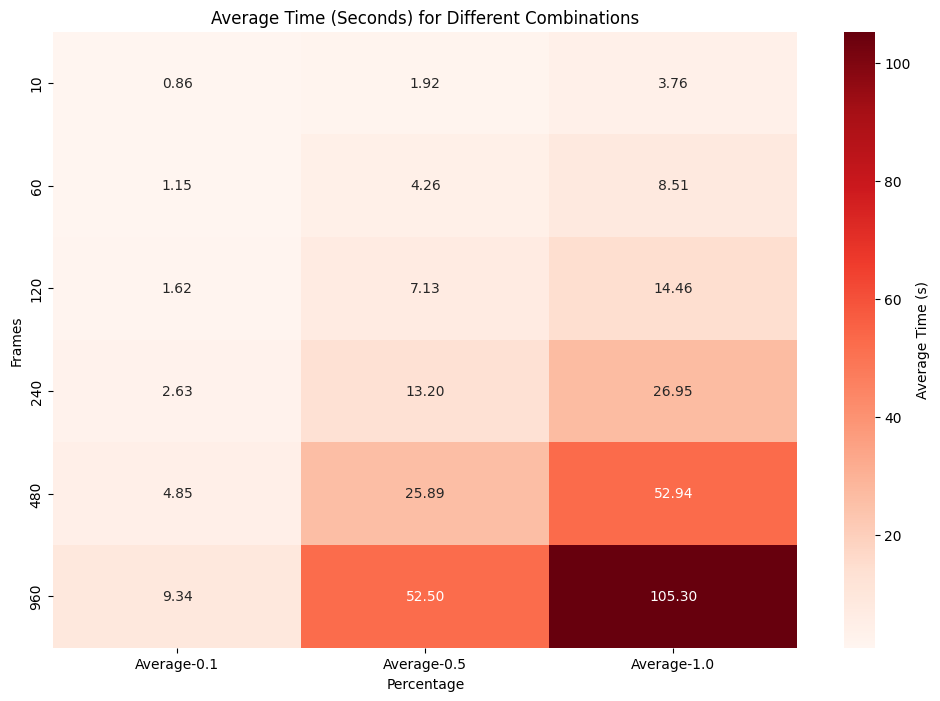

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_unstacked, annot=True, cmap='Reds', fmt=".2f", cbar_kws={'label': 'Average Time (s)'})
plt.title('Average Time (Seconds) for Different Combinations')
plt.xlabel('Percentage')
plt.ylabel('Frames')
plt.show()

# MAX FPS for uninterrupted animation per combinations

The formula used to get the max FPS, with uninterrupted animation :

$$
Max FPS = \frac{| frames |}{\max(\text{time to generate next matrix})}
$$



In [15]:
max_data = {key: max(value) for key, value in times.items()}

# Calculate the FPS values using the maximum values
fps_values = {key: key[0] / value for key, value in max_data.items()}
fps_values


{(10, 0.1): 9.282994848023556,
 (10, 0.5): 4.411616245814185,
 (10, 1): 2.4096210562406384,
 (60, 0.1): 47.55003738313872,
 (60, 0.5): 12.652560550059915,
 (60, 1): 6.476993361022506,
 (120, 0.1): 65.50431399394694,
 (120, 0.5): 15.392290082169753,
 (120, 1): 7.33261544138809,
 (240, 0.1): 81.55686355179773,
 (240, 0.5): 16.93760951624904,
 (240, 1): 8.069579979849637,
 (480, 0.1): 89.80034974244353,
 (480, 0.5): 16.602914864100825,
 (480, 1): 8.374718215787183,
 (960, 0.1): 92.63434392811236,
 (960, 0.5): 16.991070856716142,
 (960, 1): 8.459295849957947}

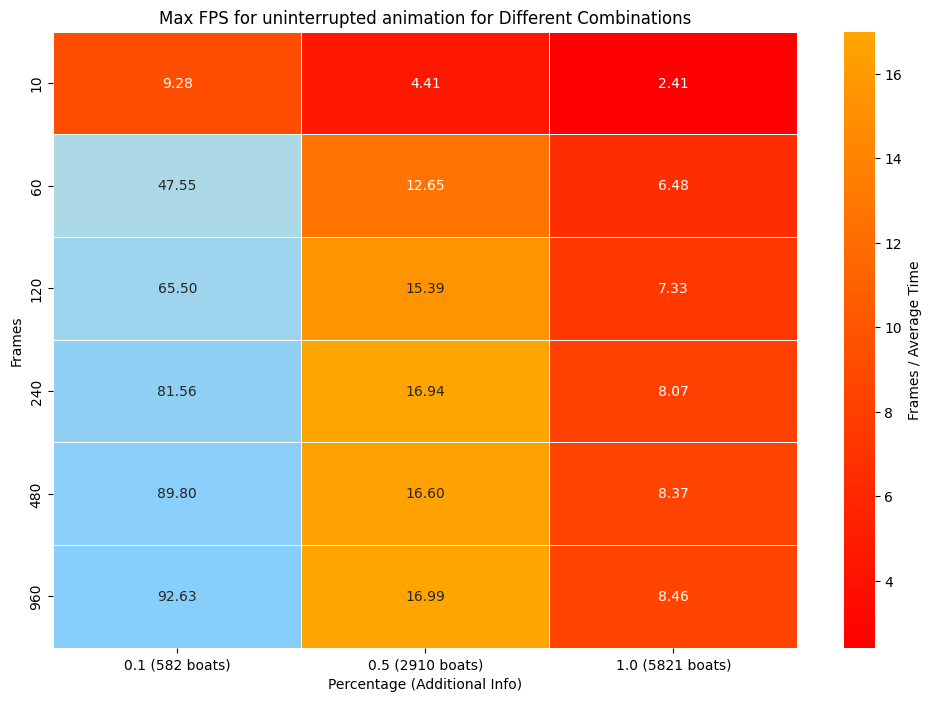

In [16]:
# fps_values = {key: key[0] / value for key, value in avg_data.items()}


df_frames_per_value = pd.DataFrame.from_dict(fps_values, orient='index', columns=['Frames_per_Value'])
df_frames_per_value.index = pd.MultiIndex.from_tuples(df_frames_per_value.index, names=['Frames', 'Percentage'])

df_frames_per_value_unstacked = df_frames_per_value.unstack(level=-1)
df_frames_per_value_unstacked.columns = [f"{col} ({number_of_objects[col]} boats)" for col in df_frames_per_value_unstacked.columns.droplevel(0)]

# for values below 30
colors_below_30 = ["red", "orange"]
cmap_below_30 = LinearSegmentedColormap.from_list("Below30Colormap", colors_below_30)

# above 30
colors_above_30 = ["#ADD8E6", "#87CEFA"]
cmap_above_30 = LinearSegmentedColormap.from_list("Above30Colormap", colors_above_30)

# Create a mask for values below and above 30
mask_below_30 = df_frames_per_value_unstacked >= 30
mask_above_30 = df_frames_per_value_unstacked < 30

# Plot the heatmap with inverted color gradient for values below 30
plt.figure(figsize=(12, 8))
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap=cmap_below_30, fmt=".2f", cbar_kws={'label': 'Frames / Average Time'}, mask=mask_below_30, linewidths=.5)
light_blue = "#add8e6"  # 
cmap_single_shade = mcolors.ListedColormap([light_blue]) 
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap=cmap_above_30, fmt=".2f", cbar=False, mask=mask_above_30, linewidths=.5)
plt.title('Max FPS for uninterrupted animation for Different Combinations')
plt.xlabel('Percentage (Additional Info)')
plt.ylabel('Frames')
plt.show()

# Memory occupied on disk by 3 matrices (t-1, t, t+1)

In [17]:
memory_used

{(10, 0.1): 0.4261188507080078,
 (10, 0.5): 2.218186378479004,
 (10, 1): 4.586123466491699,
 (60, 0.1): 2.718573570251465,
 (60, 0.5): 14.29932689666748,
 (60, 1): 29.33008861541748,
 (120, 0.1): 5.7421064376831055,
 (120, 0.5): 30.055630683898926,
 (120, 1): 61.43952751159668,
 (240, 0.1): 12.017102241516113,
 (240, 0.5): 62.22495174407959,
 (240, 1): 127.04196548461914,
 (480, 0.1): 25.28296661376953,
 (480, 0.5): 127.89240837097168,
 (480, 1): 261.0616455078125,
 (960, 0.1): 52.368592262268066,
 (960, 0.5): 266.72276306152344,
 (960, 1): 540.6614665985107}

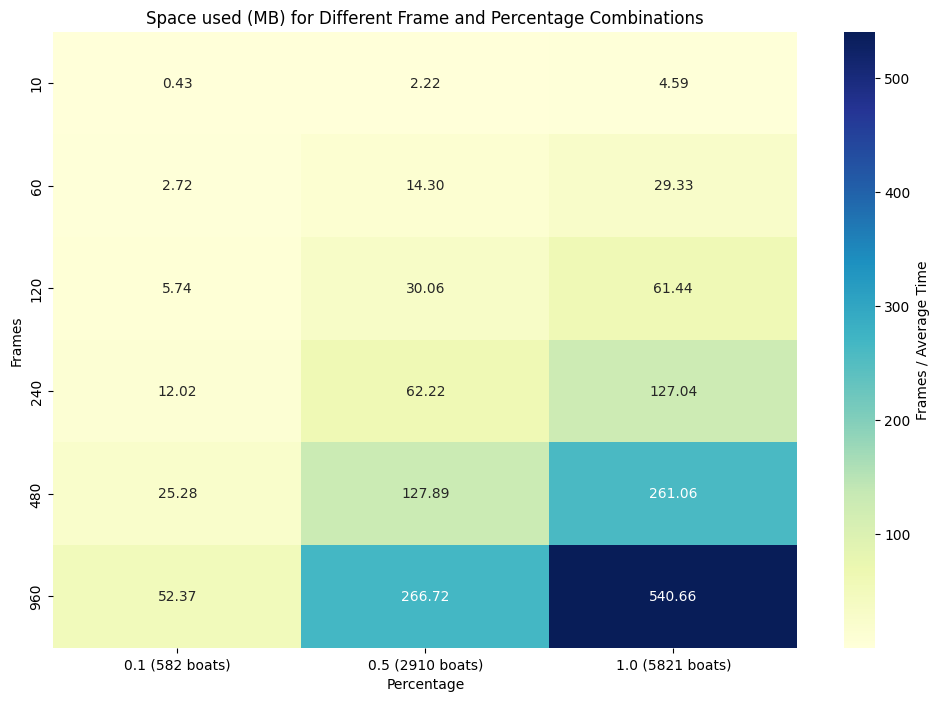

In [18]:


df_frames_per_value = pd.DataFrame.from_dict(memory_used, orient='index', columns=['%'])
df_frames_per_value.index = pd.MultiIndex.from_tuples(df_frames_per_value.index, names=['Frames', 'Percentage'])

df_frames_per_value_unstacked = df_frames_per_value.unstack(level=-1)
df_frames_per_value_unstacked.columns = [f"{col} ({number_of_objects[col]} boats)" for col in df_frames_per_value_unstacked.columns.droplevel(0)]


plt.figure(figsize=(12, 8))
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'Frames / Average Time'})
plt.title('Space used (MB) for Different Frame and Percentage Combinations')
plt.xlabel('Percentage')
plt.ylabel('Frames')
plt.show()

# Moving resampling and indexing to database

In [2]:
import numpy as np
from shapely.geometry import Point
from pymeos.db.psycopg import MobilityDB

from pymeos import *
import os
import sys
from datetime import timedelta, datetime
from pymeos import *
import time
from tqdm import tqdm
import itertools
import shutil
import math
import subprocess
from collections import deque


MATRIX_DIRECTORY_PATH ="/home/ali/matrices/" 
if os.path.exists(MATRIX_DIRECTORY_PATH):
    shutil.rmtree(MATRIX_DIRECTORY_PATH)
    os.makedirs(MATRIX_DIRECTORY_PATH)
else:
    os.makedirs(MATRIX_DIRECTORY_PATH)
pymeos_initialize()

def get_folder_size_mb(dir_name):
    total_size = 0
    sizes = deque(maxlen=3)
    for dirpath, dirnames, filenames in os.walk(dir_name):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            # Skip if it is symbolic link
            if not os.path.islink(file_path):
                sizes.append(os.path.getsize(file_path))
    # Convert size to MB
    total_size_mb = sum(sizes) / (1024 * 1024)
    return total_size_mb


"""
Iterate over all the possible combinations of frames and percentages

for each combination :
    
    Create 3 time deltas
    store : time for each time delta
    store : maximum time for each time delta
    store : average time for each time delta
    
    Calculate FPS using : Frames / maximum time for each time delta

    Store the FPS for each combination

    store the memory used by all 3 time delta in local disk


"""

SRID = 4326
DATABASE_NAME = "mobilitydb"
TPOINT_TABLE_NAME = "PyMEOS_demo"
TPOINT_ID_COLUMN_NAME = "MMSI"
TPOINT_COLUMN_NAME = "trajectory"
x_min = -180
y_min = -90
x_max = 180
y_max = 90
extent_list = [x_min, y_min, x_max, y_max]
Time_granularities = {
                    # "MILLISECOND" : timedelta(milliseconds=1),
                      "SECOND" : timedelta(seconds=1),
                      "MINUTE" : timedelta(minutes=1),
                    #   "HOUR" : timedelta(hours=1),
                    }
GRANULARITY = Time_granularities["SECOND"]

connection_params = {
        "host": "localhost",
        "port": 5432,
        "dbname": DATABASE_NAME,
        "user": "postgres",
        "password": "postgres"
        }
                
connection = MobilityDB.connect(**connection_params)
cursor = connection.cursor()

cursor.execute(f"SELECT {TPOINT_ID_COLUMN_NAME} FROM public.{TPOINT_TABLE_NAME};")
Total_ids = cursor.fetchall()

cursor.execute(f"SELECT MIN(startTimestamp({TPOINT_COLUMN_NAME})) AS earliest_timestamp FROM public.{TPOINT_TABLE_NAME};")
start_date = cursor.fetchone()[0]
cursor.execute(f"SELECT MAX(endTimestamp({TPOINT_COLUMN_NAME})) AS latest_timestamp FROM public.{TPOINT_TABLE_NAME};")
end_date = cursor.fetchone()[0]

total_frames = math.ceil( (end_date - start_date) // GRANULARITY ) + 1

timestamps = [start_date + i * GRANULARITY for i in range(total_frames)]
timestamps = [dt.replace(tzinfo=None) for dt in timestamps]
timestamps_strings = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in timestamps]


TIME_DELTA_COUNT = 10


Frames = [10, 60, 120, 240, 480, 960]
Percentages = [0.1, 0.5,  1]

number_of_objects={} # Store the number of objects for each percentage
times = {} # Store the time for each time delta
memory_used = {} # Store the memory used for each combination

combinations = tqdm(list(itertools.product(Frames, Percentages)))

for combination in combinations:
    combinations.set_description(f"Combination {combination}")
    frame, percentage = combination

    
    ids_list = Total_ids[:int(len(Total_ids)*percentage)]
    number_of_objects[percentage] = len(ids_list)


    # print(combination)
    dir_name = f"/home/ali/matrices/{frame}_{percentage}"
    # print(dir_name)
    os.mkdir(dir_name)
   
    t_deltas = tqdm([(i, (i+frame)-1) for i in range(0, 10*frame, frame)]) 
    # print(t_deltas)
    times[combination] = []
    for delta in t_deltas:
        t_deltas.set_description(f"Time delta {delta}")
        now = time.time()
        x_min,y_min, x_max, y_max = extent_list
        begin_frame, end_frame = delta
        arguments = [begin_frame, end_frame, percentage, x_min, y_min, x_max, y_max]
        arguments = [str(arg) for arg in arguments]
        arguments += [timestamps_strings[begin_frame],  str(len(timestamps)),
                'SECOND',
                dir_name,
                'mobilitydb',
                'pymeos_demo',
                'MMSI',
                'trajectory']
     

        python_path = sys.executable
        process_B_path = f"/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py"
        
        command = [python_path, process_B_path, *arguments]
        result = subprocess.run(command, capture_output=True, text=True)
        print(result)
        
        loaded_matrix = np.load(f"{dir_name}/matrix_{begin_frame}.npy", allow_pickle=True)

        TIME_total = time.time() - now
        times[combination].append(TIME_total)
    size = get_folder_size_mb(dir_name) 
    memory_used[combination] = size
    shutil.rmtree(dir_name)
        
    
    



Combination (10, 0.1):   0%|          | 0/18 [00:00<?, ?it/s]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '9', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.01602935791015625 seconds, 0.4808807373046875 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '10', '19', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:10', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 10 created in 0.02814626693725586 seconds, 0.8443880081176758 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '20', '29', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:20', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 20 created in 0.028851032257080078 seconds, 0.8655309677124023 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '30', '39', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:30', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 30 created in 0.06450104713439941 seconds, 1.9350314140319824 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '40', '49', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:40', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 40 created in 0.04708242416381836 seconds, 1.4124727249145508 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '50', '59', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:50', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 50 created in 0.043103933334350586 seconds, 1.2931180000305176 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '60', '69', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 0.04530835151672363 seconds, 1.359250545501709 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '70', '79', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:10', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 70 created in 0.061189889907836914 seconds, 1.8356966972351074 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '80', '89', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:20', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 80 created in 0.06113862991333008 seconds, 1.8341588973999023 frames for 30 fps animation.\n', stderr='')


Combination (10, 0.5):   6%|▌         | 1/18 [00:11<03:19, 11.74s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '90', '99', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:30', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 90 created in 0.06527328491210938 seconds, 1.9581985473632812 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '9', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.0946040153503418 seconds, 2.838120460510254 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '10', '19', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:10', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 10 created in 0.17810368537902832 seconds, 5.34311056137085 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '20', '29', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:20', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 20 created in 0.24137616157531738 seconds, 7.2412848472595215 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '30', '39', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:30', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 30 created in 0.1977534294128418 seconds, 5.932602882385254 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '40', '49', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:40', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 40 created in 0.2236788272857666 seconds, 6.710364818572998 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '50', '59', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:50', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 50 created in 0.3013589382171631 seconds, 9.040768146514893 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '60', '69', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 0.409806489944458 seconds, 12.29419469833374 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '70', '79', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:10', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 70 created in 0.34508609771728516 seconds, 10.352582931518555 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '80', '89', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:20', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 80 created in 0.5093040466308594 seconds, 15.279121398925781 frames for 30 fps animation.\n', stderr='')


Combination (10, 1):  11%|█         | 2/18 [00:44<06:29, 24.34s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '90', '99', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:30', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 90 created in 0.40019941329956055 seconds, 12.005982398986816 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '9', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.19836902618408203 seconds, 5.951070785522461 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '10', '19', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:10', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 10 created in 0.46758508682250977 seconds, 14.027552604675293 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '20', '29', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:20', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 20 created in 0.6540541648864746 seconds, 19.62162494659424 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '30', '39', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:30', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 30 created in 0.6134891510009766 seconds, 18.404674530029297 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '40', '49', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:40', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 40 created in 0.556842565536499 seconds, 16.70527696609497 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '50', '59', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:50', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 50 created in 0.6409707069396973 seconds, 19.229121208190918 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '60', '69', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 0.6718502044677734 seconds, 20.155506134033203 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '70', '79', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:10', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 70 created in 0.7121140956878662 seconds, 21.363422870635986 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '80', '89', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:20', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 80 created in 0.7599625587463379 seconds, 22.798876762390137 frames for 30 fps animation.\n', stderr='')


Combination (60, 0.1):  17%|█▋        | 3/18 [02:01<12:04, 48.33s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '90', '99', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:30', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 90 created in 0.8149456977844238 seconds, 24.448370933532715 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '59', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.15101051330566406 seconds, 4.530315399169922 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '60', '119', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 0.27875328063964844 seconds, 8.362598419189453 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '120', '179', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 0.37719130516052246 seconds, 11.315739154815674 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '180', '239', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:03:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 180 created in 0.36716318130493164 seconds, 11.01489543914795 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '240', '299', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 0.35015249252319336 seconds, 10.5045747756958 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '300', '359', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:05:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 300 created in 0.44074440002441406 seconds, 13.222332000732422 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '360', '419', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 0.4694666862487793 seconds, 14.084000587463379 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '420', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:07:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 420 created in 0.400540828704834 seconds, 12.01622486114502 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '539', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 0.5218126773834229 seconds, 15.654380321502686 frames for 30 fps animation.\n', stderr='')


Combination (60, 0.5):  22%|██▏       | 4/18 [02:17<08:18, 35.59s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '540', '599', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:09:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 540 created in 0.44103479385375977 seconds, 13.231043815612793 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '59', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.9451749324798584 seconds, 28.355247974395752 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '60', '119', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 2.06374192237854 seconds, 61.9122576713562 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '120', '179', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 2.2785372734069824 seconds, 68.35611820220947 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '180', '239', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:03:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 180 created in 2.2254343032836914 seconds, 66.76302909851074 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '240', '299', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 2.6967949867248535 seconds, 80.9038496017456 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '300', '359', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:05:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 300 created in 2.60164213180542 seconds, 78.0492639541626 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '360', '419', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 2.6013808250427246 seconds, 78.04142475128174 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '420', '479', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:07:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 420 created in 2.3604395389556885 seconds, 70.81318616867065 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '539', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 2.4568285942077637 seconds, 73.70485782623291 frames for 30 fps animation.\n', stderr='')


Combination (60, 1):  28%|██▊       | 5/18 [03:15<09:24, 43.42s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '540', '599', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:09:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 540 created in 2.5873806476593018 seconds, 77.62141942977905 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '59', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 2.165174722671509 seconds, 64.95524168014526 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '60', '119', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 3.800271511077881 seconds, 114.00814533233643 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '120', '179', '1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 4.406210422515869 seconds, 132.18631267547607 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '180', '239', '1', '-180', '-90', '180', '90', '2023-06-01 00:03:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 180 created in 4.754442453384399 seconds, 142.63327360153198 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '240', '299', '1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 4.7517194747924805 seconds, 142.5515842437744 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '300', '359', '1', '-180', '-90', '180', '90', '2023-06-01 00:05:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 300 created in 4.764132499694824 seconds, 142.92397499084473 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '360', '419', '1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 4.812184810638428 seconds, 144.36554431915283 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '420', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:07:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 420 created in 4.996489524841309 seconds, 149.89468574523926 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '539', '1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 4.937875032424927 seconds, 148.1362509727478 frames for 30 fps animation.\n', stderr='')


Combination (120, 0.1):  33%|███▎      | 6/18 [05:13<13:45, 68.77s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '540', '599', '1', '-180', '-90', '180', '90', '2023-06-01 00:09:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 540 created in 5.494800090789795 seconds, 164.84400272369385 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '119', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.39066576957702637 seconds, 11.719973087310791 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '120', '239', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 0.6750831604003906 seconds, 20.25249481201172 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '240', '359', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 0.8362398147583008 seconds, 25.087194442749023 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '360', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 0.7981531620025635 seconds, 23.944594860076904 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '599', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 0.7830524444580078 seconds, 23.491573333740234 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '600', '719', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:10:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 600 created in 0.7427170276641846 seconds, 22.281510829925537 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '720', '839', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 0.7839560508728027 seconds, 23.518681526184082 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '840', '959', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:14:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 840 created in 0.8647563457489014 seconds, 25.94269037246704 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1079', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 0.8218662738800049 seconds, 24.655988216400146 frames for 30 fps animation.\n', stderr='')


Combination (120, 0.5):  39%|███▉      | 7/18 [05:32<09:38, 52.58s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1080', '1199', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:18:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1080 created in 0.8143308162689209 seconds, 24.429924488067627 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '119', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 2.294212818145752 seconds, 68.82638454437256 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '120', '239', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 4.27452278137207 seconds, 128.2356834411621 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '240', '359', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 4.67614483833313 seconds, 140.2843451499939 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '360', '479', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 4.802713871002197 seconds, 144.08141613006592 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '599', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 4.913382530212402 seconds, 147.40147590637207 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '600', '719', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:10:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 600 created in 4.966646909713745 seconds, 148.99940729141235 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '720', '839', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 4.966531753540039 seconds, 148.99595260620117 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '840', '959', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:14:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 840 created in 5.110257148742676 seconds, 153.30771446228027 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1079', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 5.325507640838623 seconds, 159.7652292251587 frames for 30 fps animation.\n', stderr='')


Combination (120, 1):  44%|████▍     | 8/18 [06:55<10:22, 62.30s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1080', '1199', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:18:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1080 created in 4.953108072280884 seconds, 148.5932421684265 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '119', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 5.974079847335815 seconds, 179.22239542007446 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '120', '239', '1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 9.198783874511719 seconds, 275.96351623535156 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '240', '359', '1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 9.641850471496582 seconds, 289.25551414489746 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '360', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 9.947360754013062 seconds, 298.42082262039185 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '599', '1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 10.162171840667725 seconds, 304.86515522003174 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '600', '719', '1', '-180', '-90', '180', '90', '2023-06-01 00:10:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 600 created in 10.253827095031738 seconds, 307.61481285095215 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '720', '839', '1', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 10.269580125808716 seconds, 308.0874037742615 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '840', '959', '1', '-180', '-90', '180', '90', '2023-06-01 00:14:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 840 created in 10.416446685791016 seconds, 312.49340057373047 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1079', '1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 10.259891033172607 seconds, 307.7967309951782 frames for 30 fps animation.\n', stderr='')


Combination (240, 0.1):  50%|█████     | 9/18 [09:54<14:48, 98.67s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1080', '1199', '1', '-180', '-90', '180', '90', '2023-06-01 00:18:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1080 created in 10.79442811012268 seconds, 323.8328433036804 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '239', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.8631346225738525 seconds, 25.894038677215576 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '240', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 1.4381492137908936 seconds, 43.14447641372681 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '719', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 1.5407607555389404 seconds, 46.22282266616821 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '720', '959', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 1.5721149444580078 seconds, 47.163448333740234 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1199', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 1.7391316890716553 seconds, 52.17395067214966 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1200', '1439', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:20:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1200 created in 1.6672799587249756 seconds, 50.01839876174927 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1440', '1679', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 1.8156731128692627 seconds, 54.47019338607788 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1680', '1919', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:28:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1680 created in 1.8062291145324707 seconds, 54.18687343597412 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1920', '2159', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 1.7874174118041992 seconds, 53.62252235412598 frames for 30 fps animation.\n', stderr='')


Combination (240, 0.5):  56%|█████▌    | 10/18 [10:23<10:17, 77.16s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2160', '2399', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:36:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2160 created in 1.860288381576538 seconds, 55.80865144729614 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '239', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 6.335111856460571 seconds, 190.05335569381714 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '240', '479', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 9.289870738983154 seconds, 278.69612216949463 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '719', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 9.910153865814209 seconds, 297.30461597442627 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '720', '959', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 10.510707139968872 seconds, 315.32121419906616 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1199', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 10.199171304702759 seconds, 305.97513914108276 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1200', '1439', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:20:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1200 created in 10.582489252090454 seconds, 317.4746775627136 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1440', '1679', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 10.461893558502197 seconds, 313.8568067550659 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1680', '1919', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:28:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1680 created in 10.604980230331421 seconds, 318.1494069099426 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1920', '2159', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 10.520252466201782 seconds, 315.60757398605347 frames for 30 fps animation.\n', stderr='')


Combination (240, 1):  61%|██████    | 11/18 [12:45<11:19, 97.09s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2160', '2399', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:36:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2160 created in 10.84672474861145 seconds, 325.4017424583435 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '239', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 13.29535436630249 seconds, 398.8606309890747 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '240', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 19.07308578491211 seconds, 572.1925735473633 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '719', '1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 19.721476554870605 seconds, 591.6442966461182 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '720', '959', '1', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 21.55629801750183 seconds, 646.6889405250549 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1199', '1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 21.433693170547485 seconds, 643.0107951164246 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1200', '1439', '1', '-180', '-90', '180', '90', '2023-06-01 00:20:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1200 created in 20.973304510116577 seconds, 629.1991353034973 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1440', '1679', '1', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 21.206797122955322 seconds, 636.2039136886597 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1680', '1919', '1', '-180', '-90', '180', '90', '2023-06-01 00:28:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1680 created in 21.892269134521484 seconds, 656.7680740356445 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1920', '2159', '1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 22.17791986465454 seconds, 665.3375959396362 frames for 30 fps animation.\n', stderr='')


Time delta (2160, 2399): 100%|██████████| 10/10 [04:56<00:00, 29.66s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2160', '2399', '1', '-180', '-90', '180', '90', '2023-06-01 00:36:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2160 created in 21.586501598358154 seconds, 647.5950479507446 frames for 30 fps animation.\n', stderr='')



Combination (480, 0.1):  67%|██████▋   | 12/18 [17:42<15:46, 157.80s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 2.157926559448242 seconds, 64.73779678344727 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '959', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 3.1164417266845703 seconds, 93.49325180053711 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1439', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 3.4047586917877197 seconds, 102.14276075363159 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1440', '1919', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 3.602094888687134 seconds, 108.06284666061401 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1920', '2399', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 3.7407875061035156 seconds, 112.22362518310547 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2400', '2879', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:40:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2400 created in 3.6465067863464355 seconds, 109.39520359039307 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2880', '3359', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 3.6426150798797607 seconds, 109.27845239639282 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '3360', '3839', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:56:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3360 created in 3.7965478897094727 seconds, 113.89643669128418 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '3840', '4319', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 3.7918360233306885 seconds, 113.75508069992065 frames for 30 fps animation.\n', stderr='')


Combination (480, 0.5):  72%|███████▏  | 13/18 [18:32<10:25, 125.17s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '4320', '4799', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:12:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4320 created in 3.884882688522339 seconds, 116.54648065567017 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '479', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 14.931513547897339 seconds, 447.94540643692017 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '959', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 19.722604751586914 seconds, 591.6781425476074 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1439', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 20.552061796188354 seconds, 616.5618538856506 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1440', '1919', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 21.075875282287598 seconds, 632.2762584686279 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1920', '2399', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 21.79607629776001 seconds, 653.8822889328003 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2400', '2879', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:40:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2400 created in 21.939401149749756 seconds, 658.1820344924927 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2880', '3359', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 22.155344009399414 seconds, 664.6603202819824 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '3360', '3839', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:56:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3360 created in 22.179920196533203 seconds, 665.3976058959961 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '3840', '4319', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 22.35197138786316 seconds, 670.5591416358948 frames for 30 fps animation.\n', stderr='')


Time delta (4320, 4799): 100%|██████████| 10/10 [04:24<00:00, 26.47s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '4320', '4799', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:12:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4320 created in 22.416417121887207 seconds, 672.4925136566162 frames for 30 fps animation.\n', stderr='')



Combination (480, 1):  78%|███████▊  | 14/18 [22:56<11:09, 167.35s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 31.632792711257935 seconds, 948.983781337738 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '959', '1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 41.65047764778137 seconds, 1249.5143294334412 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1439', '1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 42.979511976242065 seconds, 1289.385359287262 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1440', '1919', '1', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 43.236207485198975 seconds, 1297.0862245559692 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1920', '2399', '1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 44.76738500595093 seconds, 1343.0215501785278 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2400', '2879', '1', '-180', '-90', '180', '90', '2023-06-01 00:40:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2400 created in 43.96168518066406 seconds, 1318.8505554199219 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2880', '3359', '1', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 44.92502188682556 seconds, 1347.7506566047668 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '3360', '3839', '1', '-180', '-90', '180', '90', '2023-06-01 00:56:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3360 created in 45.059584856033325 seconds, 1351.7875456809998 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '3840', '4319', '1', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 45.9108190536499 seconds, 1377.324571609497 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '4320', '4799', '1', '-180', '-90', '180', '90', '2023-06-01 01:12:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4320 created in 44.957205057144165 seconds, 1348.716151714325 frames for 30 fps animation.\n', stderr='')


Combination (960, 0.1):  83%|████████▎ | 15/18 [32:06<14:07, 282.50s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '959', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 4.946508407592773 seconds, 148.3952522277832 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1919', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 6.735979795455933 seconds, 202.07939386367798 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1920', '2879', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 7.284067153930664 seconds, 218.52201461791992 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2880', '3839', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 7.389312028884888 seconds, 221.67936086654663 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '3840', '4799', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 9.564356327056885 seconds, 286.93068981170654 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '4800', '5759', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:20:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4800 created in 8.085799217224121 seconds, 242.57397651672363 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '5760', '6719', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:36:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 5760 created in 7.858319997787476 seconds, 235.74959993362427 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '6720', '7679', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:52:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 6720 created in 8.104739665985107 seconds, 243.14218997955322 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '7680', '8639', '0.1', '-180', '-90', '180', '90', '2023-06-01 02:08:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 7680 created in 8.31891417503357 seconds, 249.56742525100708 frames for 30 fps animation.\n', stderr='')


Combination (960, 0.5):  89%|████████▉ | 16/18 [33:42<07:33, 226.52s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '8640', '9599', '0.1', '-180', '-90', '180', '90', '2023-06-01 02:24:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 8640 created in 8.300793170928955 seconds, 249.02379512786865 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '959', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 34.63522148132324 seconds, 1039.0566444396973 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1919', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 40.71933889389038 seconds, 1221.5801668167114 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1920', '2879', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 42.46389603614807 seconds, 1273.9168810844421 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2880', '3839', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 44.178181648254395 seconds, 1325.3454494476318 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '3840', '4799', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 44.0610134601593 seconds, 1321.830403804779 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '4800', '5759', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:20:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4800 created in 45.28465676307678 seconds, 1358.5397028923035 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '5760', '6719', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:36:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 5760 created in 48.79796528816223 seconds, 1463.938958644867 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '6720', '7679', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:52:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 6720 created in 45.96626138687134 seconds, 1378.9878416061401 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '7680', '8639', '0.5', '-180', '-90', '180', '90', '2023-06-01 02:08:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 7680 created in 46.36343455314636 seconds, 1390.9030365943909 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '8640', '9599', '0.5', '-180', '-90', '180', '90', '2023-06-01 02:24:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 8640 created in 47.64606332778931 seconds, 1429.3818998336792 frames for 30 fps animation.\n', stderr='')


Combination (960, 1):  94%|█████████▍| 17/18 [42:24<05:15, 315.22s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '959', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 70.33918142318726 seconds, 2110.1754426956177 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1919', '1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 83.53909683227539 seconds, 2506.1729049682617 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1920', '2879', '1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 89.14542388916016 seconds, 2674.3627166748047 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2880', '3839', '1', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 91.51139426231384 seconds, 2745.3418278694153 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '3840', '4799', '1', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 92.12568211555481 seconds, 2763.7704634666443 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '4800', '5759', '1', '-180', '-90', '180', '90', '2023-06-01 01:20:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4800 created in 93.08521366119385 seconds, 2792.5564098358154 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '5760', '6719', '1', '-180', '-90', '180', '90', '2023-06-01 01:36:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 5760 created in 92.96470403671265 seconds, 2788.9411211013794 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '6720', '7679', '1', '-180', '-90', '180', '90', '2023-06-01 01:52:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 6720 created in 94.16120290756226 seconds, 2824.8360872268677 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '7680', '8639', '1', '-180', '-90', '180', '90', '2023-06-01 02:08:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 7680 created in 93.4968810081482 seconds, 2804.906430244446 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '8640', '9599', '1', '-180', '-90', '180', '90', '2023-06-01 02:24:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 8640 created in 95.62428069114685 seconds, 2868.7284207344055 frames for 30 fps animation.\n', stderr='')


Combination (960, 1): 100%|██████████| 18/18 [1:00:12<00:00, 200.71s/it]


# Average time for different combinations

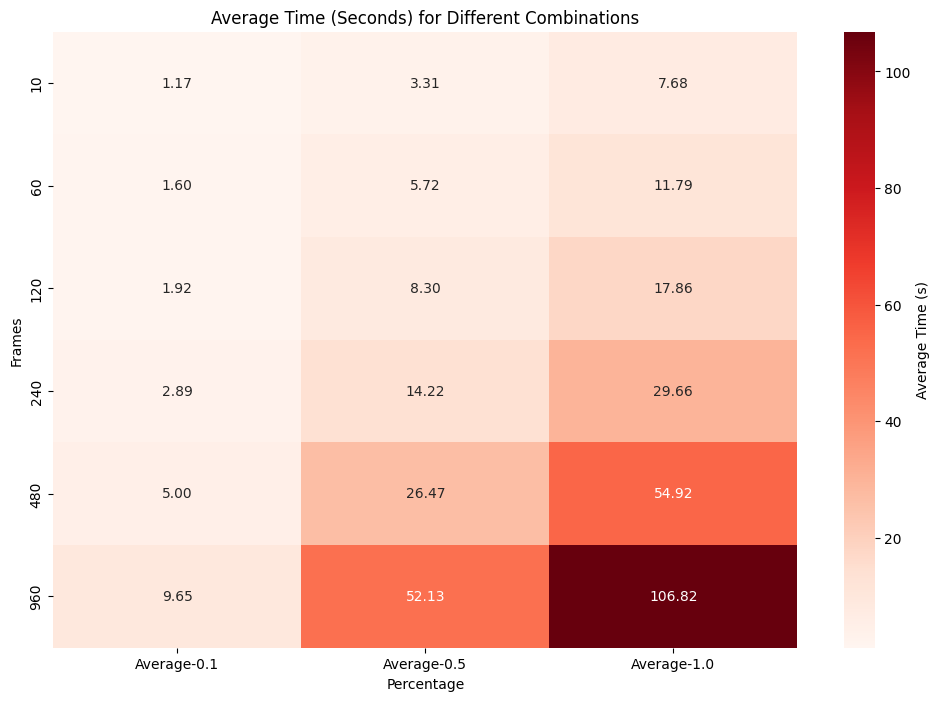

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

avg_data = {key: np.mean(value) for key, value in times.items()}
avg_data

df = pd.DataFrame.from_dict(avg_data, orient='index', columns=['Average'])
df.index = pd.MultiIndex.from_tuples(df.index, names=['Frames', 'Percentage'])

df
df_unstacked = df.unstack(level=-1) 
df_unstacked
plt.figure(figsize=(12, 8))
sns.heatmap(df_unstacked, annot=True, cmap='Reds', fmt=".2f", cbar_kws={'label': 'Average Time (s)'})
plt.title('Average Time (Seconds) for Different Combinations')
plt.xlabel('Percentage')
plt.ylabel('Frames')
plt.show()

# Max FPS for uninterrupted annimation 

The formula used to get the max FPS, with uninterrupted animation :

$$
Max FPS = \frac{| frames |}{\max(\text{time to generate next matrix})}
$$

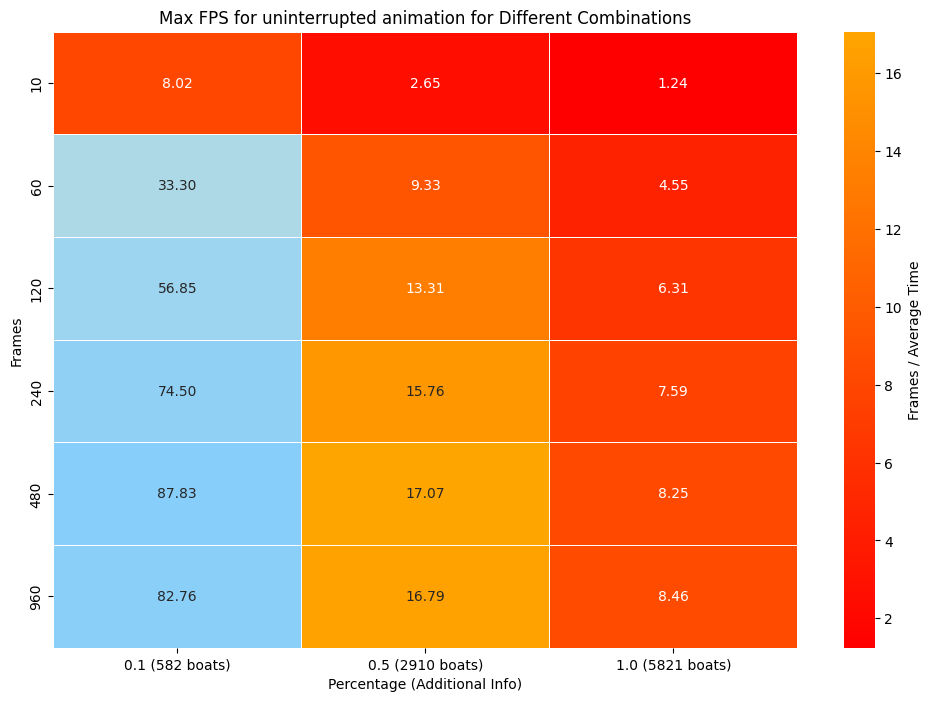

In [4]:
max_data = {key: max(value) for key, value in times.items()}

# Calculate the FPS values using the maximum values
fps_values = {key: key[0] / value for key, value in max_data.items()}
fps_values
# fps_values = {key: key[0] / value for key, value in avg_data.items()}


df_frames_per_value = pd.DataFrame.from_dict(fps_values, orient='index', columns=['Frames_per_Value'])
df_frames_per_value.index = pd.MultiIndex.from_tuples(df_frames_per_value.index, names=['Frames', 'Percentage'])

df_frames_per_value_unstacked = df_frames_per_value.unstack(level=-1)
df_frames_per_value_unstacked.columns = [f"{col} ({number_of_objects[col]} boats)" for col in df_frames_per_value_unstacked.columns.droplevel(0)]

# for values below 30
colors_below_30 = ["red", "orange"]
cmap_below_30 = LinearSegmentedColormap.from_list("Below30Colormap", colors_below_30)

# above 30
colors_above_30 = ["#ADD8E6", "#87CEFA"]
cmap_above_30 = LinearSegmentedColormap.from_list("Above30Colormap", colors_above_30)

# Create a mask for values below and above 30
mask_below_30 = df_frames_per_value_unstacked >= 30
mask_above_30 = df_frames_per_value_unstacked < 30

# Plot the heatmap with inverted color gradient for values below 30
plt.figure(figsize=(12, 8))
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap=cmap_below_30, fmt=".2f", cbar_kws={'label': 'Frames / Average Time'}, mask=mask_below_30, linewidths=.5)
light_blue = "#add8e6"  # 
cmap_single_shade = mcolors.ListedColormap([light_blue]) 
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap=cmap_above_30, fmt=".2f", cbar=False, mask=mask_above_30, linewidths=.5)
plt.title('Max FPS for uninterrupted animation for Different Combinations')
plt.xlabel('Percentage (Additional Info)')
plt.ylabel('Frames')
plt.show()

# Memory occupied by 3 deltas

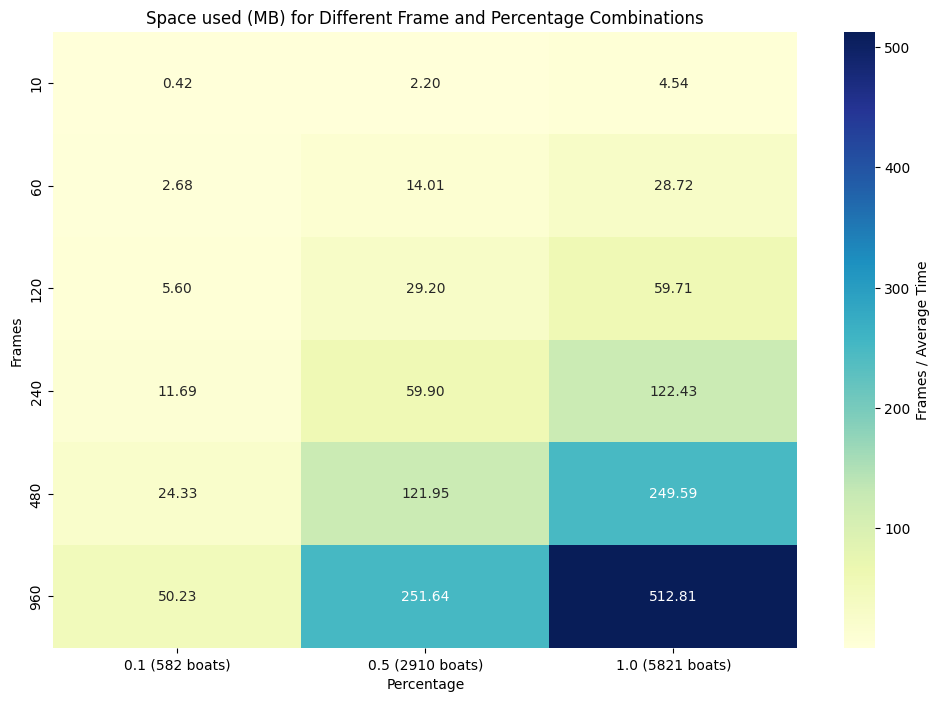

In [5]:


df_frames_per_value = pd.DataFrame.from_dict(memory_used, orient='index', columns=['%'])
df_frames_per_value.index = pd.MultiIndex.from_tuples(df_frames_per_value.index, names=['Frames', 'Percentage'])

df_frames_per_value_unstacked = df_frames_per_value.unstack(level=-1)
df_frames_per_value_unstacked.columns = [f"{col} ({number_of_objects[col]} boats)" for col in df_frames_per_value_unstacked.columns.droplevel(0)]


plt.figure(figsize=(12, 8))
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'Frames / Average Time'})
plt.title('Space used (MB) for Different Frame and Percentage Combinations')
plt.xlabel('Percentage')
plt.ylabel('Frames')
plt.show()